## 1a. Scraping data from website au.indeed.com (without estimate salary)

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import time
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def keyword_query(keyword):
    """
    Takes Indeed parameters, converts, and returns it into appropriate query format.    
    """
    
    url = "https://au.indeed.com/jobs?q="
    for word in keyword.split():
        url += word + '+'
    url = url + '&l={}&start={}'
    return url

def keyword_query_with_estimate_salary(keyword, estimate_salary):
    """
    Takes Indeed parameters and estimate salary, converts, and returns it into appropriate query format.    
    """
    
    url = "https://au.indeed.com/jobs?q="
 
    for word in keyword.split():
        url += word + '+'
    url = url + '%24' + str(estimate_salary[:-3]) + '%2C000&l={}&start={}'
    return url

In [125]:
# functions to get city, title, company, salary, summary from the post

def extract_text(query):
    if query:
        return query.text.strip() # cut off whitespaces (if any) at the begining and the end of the text
    else:
        return None  


def get_title_from_post(div):
    try:
        return extract_text(div.find('a', {'data-tn-element':'jobTitle'}))
    except:
        return 'NA'


def get_company_from_post(div):
    try:
        return extract_text(div.find('span', {'class' : 'company'}))
    except:
        return 'NA'


def get_location_from_post(div):
    try:
        return extract_text(div.find('span', {'class' : 'location'}))
    except:
        return 'NA'


def get_summary_from_post(div):
    try:
        return extract_text(div.find('span', {'class' : 'summary'}))
    except:
        return 'NA'



def get_salary_from_post(div):
    if div.find('span', {'class' : 'no-wrap'}):        
        return div.find('span', {'class' : 'no-wrap'}).text
    else:
        return None


def get_job_desc_from_post(div):
    
    tags = div.find('a')
    #job_url = tags['href']
    if 'https://au.indeed.com/' not in tags['href']:
        job_url = 'https://au.indeed.com/' + tags['href']
        
    job_page = requests.get(job_url)
    soup2 = BeautifulSoup(job_page.text, 'lxml')
    soup2.prettify()
    desc = soup2.find('span', {'id' : 'job_summary'})
    #desc = soup2.find('td', {'class' : 'snip'})
    #desc_1 = desc.find('span')
    return (extract_text(desc))
    

    
def extract_posts_to_df(keyword=[], city_set=[], max_page_per_city=int):
    """
       Extracts city, state, company, summary and title from posts on indeed.
       
       Arguments:
           max_page_per_city:  integer 
           city_set: list of cities
           keyword_set: list of keywords
       
       Returns a Pandas DataFrame 
    """
    
    url_template = keyword_query(keyword)
    
    job_post = defaultdict(list)
    city_new = ''
    url =''
    
    for city in city_set:
        #print(city)
        #adding '+' between words in city name
        for city_w in city.split():
            city_new += city_w + '+'
        city_new = city_new[:-1] 
        for start in range(0,max_page_per_city):
            page = str(start) + '0'
            url = url_template.format(city_new,page)
            page = requests.get(url)
            #time.sleep(1)  #ensuring at least 1 second between page grabs
            soup = BeautifulSoup(page.text, 'lxml')
            soup.prettify()
                       
            for div in soup.find_all(name='div', attrs={'class':'row'}):
                job_post['city'].append(city)
                job_post['title'].append(get_title_from_post(div))
                job_post['company'].append(get_company_from_post(div))
                job_post['location'].append(get_location_from_post(div))
                job_post['summary'].append(get_summary_from_post(div))
                job_post['salary'].append(get_salary_from_post(div))
                job_post['job_description'].append(get_job_desc_from_post(div))
        city_new = ''
        url = url_template
    df = pd.DataFrame.from_records(job_post)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df


def extract_posts_with_estimate_salary_to_df(keyword=[], city_set=[], estimate_salary=[], max_page_per_city=int):
    """
       Extracts city, state, company, summary and title from posts on indeed.
       For those job posts having salary range, we use it.
       For those job post doesnt have salary information, we assign the salary value is the estimate salary value
       
       Arguments:
           max_page_per_city:  integer 
           city_set: list of cities
           keyword_set: list of keywords
           estimate_salary
       
       Returns a Pandas DataFrame 
    """
    
    url_template = keyword_query_with_estimate_salary(keyword, estimate_salary)
    
    job_post2 = defaultdict(list)
    city_new = ''
    url =''
    
    for city in city_set:
        #print(city)
        #adding '+' between words in city name
        for city_w in city.split():
            city_new += city_w + '+'
        city_new = city_new[:-1] 
        
        for start in range(0,max_page_per_city):
            page = str(start) + '0'
            url = url_template.format(city_new,page)
            page = requests.get(url)
            #time.sleep(1)  #ensuring at least 1 second between page grabs
            soup = BeautifulSoup(page.text, 'lxml')
            soup.prettify()
                       
            for div in soup.find_all(name='div', attrs={'class':'row'}):
                job_post2['city'].append(city)
                job_post2['title'].append(get_title_from_post(div))
                job_post2['company'].append(get_company_from_post(div))
                job_post2['location'].append(get_location_from_post(div))
                job_post2['summary'].append(get_summary_from_post(div))
                if (get_salary_from_post(div) != None):
                    job_post2['salary'].append(get_salary_from_post(div))
                else:
                    job_post2['salary'].append(estimate_salary)
                job_post2['job_description'].append(get_job_desc_from_post(div))
                
        city_new = ''
        url = url_template
        
    df2 = pd.DataFrame.from_records(job_post2)
    df2.drop_duplicates(inplace=True)
    df2.reset_index(drop=True, inplace=True)
    
    return df2

In [90]:
cities = ['Sydney NSW', 'Melbourne VIC', 'Canberra ACT', 'Brisbane QLD', 'Adelaide SA', 'Perth WA', 'Gold Coast QLD']

In [ ]:
# data scientist jobs

In [20]:
data_scientist= extract_posts_to_df(keyword='Data Scientist', city_set=cities, max_page_per_city=11)

In [21]:
data_scientist.shape

(286, 7)

In [22]:
# checking how many rows with None in salary
len(data_scientist[data_scientist.salary.isnull()])

228

In [197]:
# drop rows with Nan in salary col
data_scientist.dropna(axis=0, subset=['salary'], inplace = True)

In [198]:
data_scientist.shape

(58, 7)

In [ ]:
# data analyst jobs

In [25]:
data_analyst= extract_posts_to_df(keyword='Data Analyst', city_set=cities, max_page_per_city=11)

In [28]:
data_analyst.shape

(611, 7)

In [27]:
len(data_analyst[data_analyst.salary.isnull()])

529

In [199]:
# drop rows with Nan in salary col
data_analyst.dropna(axis=0, subset=['salary'], inplace = True)

In [200]:
data_analyst.shape

(82, 7)

In [ ]:
# data engineer jobs

In [29]:
data_engineer = extract_posts_to_df(keyword='Data Engineer', city_set=cities, max_page_per_city=11)

In [30]:
data_engineer.shape

(656, 7)

In [31]:
len(data_engineer[data_engineer.salary.isnull()])

536

In [201]:
# drop rows with Nan in salary col
data_engineer.dropna(axis=0, subset=['salary'], inplace = True)

In [202]:
data_engineer.shape

(120, 7)

In [ ]:
# research scientist jobs

In [176]:
data_research_scientist=extract_posts_to_df(keyword='Research Scientist', city_set=cities2, max_page_per_city=5)

In [177]:
data_research_scientist.shape

(93, 7)

In [203]:
# drop rows with Nan in salary col
data_research_scientist.dropna(axis=0, subset=['salary'], inplace = True)

In [204]:
data_research_scientist.shape

(21, 7)

In [ ]:
# business intelligence jobs

In [35]:
data_bi = extract_posts_to_df(keyword='Business Intelligence,', city_set=cities, max_page_per_city=11)

In [36]:
data_bi.shape

(601, 7)

In [37]:
len(data_bi[data_bi.salary.isnull()])

510

In [42]:
# drop all rows have NaN in salary col
data_bi.dropna(axis=0, subset=['salary'], inplace = True)

In [81]:
data_bi.shape

(91, 7)

### Combine these datasets

In [205]:
frames = [data_scientist, data_analyst, data_engineer, data_research_scientist, data_bi]

In [206]:
data1 = pd.concat(frames)

In [207]:
data1.shape

(372, 7)

## 1b. Scraping data from au.indeed.com with estimate salary 

#### Data Scientist job with estimate salary 80k, 100k, 120k,140k, 160k

In [77]:
data_scientist_80k = extract_posts_with_estimate_salary_to_df(keyword='Data Scientist', city_set=cities, estimate_salary ='80000',max_page_per_city=6)

In [83]:
data_scientist_100k = extract_posts_with_estimate_salary_to_df(keyword='Data Scientist', city_set=cities, estimate_salary ='100000',max_page_per_city=5)

In [126]:
cities2 = ['Sydney NSW', 'Melbourne VIC', 'Canberra ACT']
data_scientist_120k = extract_posts_with_estimate_salary_to_df(keyword='Data Scientist', city_set=cities2, estimate_salary ='120000',max_page_per_city=2)

In [140]:
# there is no Scientist job 120k
cities3 = ['Brisbane QLD', 'Perth WA', 'Adelaide SA']
data_scientist_120k_3 = extract_posts_with_estimate_salary_to_df(keyword='Data Scientist', city_set=cities3, estimate_salary ='120000',max_page_per_city=2)

In [143]:
data_scientist_140k = extract_posts_with_estimate_salary_to_df(keyword='Data Scientist', city_set=cities2, estimate_salary ='140000',max_page_per_city=2)

In [145]:
data_scientist_160k = extract_posts_with_estimate_salary_to_df(keyword='Data Scientist', city_set=cities2, estimate_salary ='160000',max_page_per_city=2)

In [209]:
frames_data_scientist = [data_scientist_80k, data_scientist_100k, data_scientist_120k, data_scientist_120k_3, data_scientist_140k, data_scientist_160k]

In [210]:
data_scientist_with_est_sal = pd.concat(frames_data_scientist)

In [211]:
data_scientist_with_est_sal.shape

(468, 7)

#### Data Analyst job with estimate salary 80k, 100k, 120k,140k, 160k

In [148]:
data_analyst_80k = extract_posts_with_estimate_salary_to_df(keyword='Data Analyst', city_set=cities, estimate_salary ='80000',max_page_per_city=6)

In [150]:
data_analyst_100k = extract_posts_with_estimate_salary_to_df(keyword='Data Analyst', city_set=cities, estimate_salary ='100000',max_page_per_city=5)

In [152]:
data_analyst_120k = extract_posts_with_estimate_salary_to_df(keyword='Data Analyst', city_set=cities2, estimate_salary ='120000',max_page_per_city=2)

In [163]:
data_analyst_120k_3 = extract_posts_with_estimate_salary_to_df(keyword='Data Analyst', city_set=cities3, estimate_salary ='120000',max_page_per_city=2)

In [153]:
data_analyst_140k = extract_posts_with_estimate_salary_to_df(keyword='Data Analyst', city_set=cities2, estimate_salary ='140000',max_page_per_city=2)

In [154]:
data_analyst_160k = extract_posts_with_estimate_salary_to_df(keyword='Data Analyst', city_set=cities2, estimate_salary ='160000',max_page_per_city=2)

In [213]:
frames_data_analyst = [data_analyst_80k, data_analyst_100k, data_analyst_120k, data_analyst_120k_3, data_analyst_140k, data_analyst_160k]

In [214]:
data_analyst_with_est_sal = pd.concat(frames_data_analyst)

In [215]:
data_analyst_with_est_sal.shape

(911, 7)

#### Data Engineer job with estimate salary 80k, 100k, 120k,140k, 160k

In [159]:
data_engineer_80k = extract_posts_with_estimate_salary_to_df(keyword='Data Engineer', city_set=cities, estimate_salary ='80000',max_page_per_city=6)

In [160]:
data_engineer_100k = extract_posts_with_estimate_salary_to_df(keyword='Data Engineer', city_set=cities, estimate_salary ='100000',max_page_per_city=5)

In [161]:
data_engineer_120k = extract_posts_with_estimate_salary_to_df(keyword='Data Engineer', city_set=cities2, estimate_salary ='120000',max_page_per_city=5)

In [166]:
data_engineer_120k_3 = extract_posts_with_estimate_salary_to_df(keyword='Data Engineer', city_set=cities3, estimate_salary ='120000',max_page_per_city=2)

In [165]:
data_engineer_140k = extract_posts_with_estimate_salary_to_df(keyword='Data Engineer', city_set=cities2, estimate_salary ='140000',max_page_per_city=4)

In [216]:
data_engineer_140k_3 = extract_posts_with_estimate_salary_to_df(keyword='Data Engineer', city_set=cities3, estimate_salary ='140000',max_page_per_city=2)

In [162]:
data_engineer_160k = extract_posts_with_estimate_salary_to_df(keyword='Data Engineer', city_set=cities2, estimate_salary ='160000',max_page_per_city=2)

In [217]:
data_engineer_160k_3 = extract_posts_with_estimate_salary_to_df(keyword='Data Engineer', city_set=cities3, estimate_salary ='160000',max_page_per_city=2)

In [219]:
frames_data_engineer = [data_engineer_80k, data_engineer_100k, data_engineer_120k, data_engineer_120k_3, data_engineer_140k, data_engineer_140k_3, data_engineer_160k, data_engineer_160k_3]

In [220]:
data_engineer_with_est_sal = pd.concat(frames_data_engineer)

In [221]:
data_engineer_with_est_sal.shape

(1092, 7)

#### Research Scientist with estimate salary 70k, 90k, 110k, 130k

As the Research Scientist jobs are not popular as other jobs, we only scrape data on 3 big cities: Sydney NSW, Melbourne VIC, Canberra ACT

In [170]:
reseacrh_scientist_70k = extract_posts_with_estimate_salary_to_df(keyword='Research Scientist', city_set=cities2, estimate_salary ='70000',max_page_per_city=6)

In [190]:
reseacrh_scientist_70k_3 = extract_posts_with_estimate_salary_to_df(keyword='Research Scientist', city_set=cities3, estimate_salary ='70000',max_page_per_city=1)

In [172]:
reseacrh_scientist_90k = extract_posts_with_estimate_salary_to_df(keyword='Research Scientist', city_set=cities2, estimate_salary ='90000',max_page_per_city=3)

In [192]:
reseacrh_scientist_90k_3 = extract_posts_with_estimate_salary_to_df(keyword='Research Scientist', city_set=cities3, estimate_salary ='90000',max_page_per_city=1)

In [173]:
reseacrh_scientist_110k = extract_posts_with_estimate_salary_to_df(keyword='Research Scientist', city_set=cities2, estimate_salary ='110000',max_page_per_city=2)

In [195]:
reseacrh_scientist_110k_3 = extract_posts_with_estimate_salary_to_df(keyword='Research Scientist', city_set=cities3, estimate_salary ='110000',max_page_per_city=1)

In [183]:
reseacrh_scientist_130k = extract_posts_with_estimate_salary_to_df(keyword='Research Scientist', city_set=cities2, estimate_salary ='130000',max_page_per_city=1)

In [222]:
frames_reseacrh_scientist = [reseacrh_scientist_70k, reseacrh_scientist_70k_3, reseacrh_scientist_90k, reseacrh_scientist_90k_3, reseacrh_scientist_110k, reseacrh_scientist_110k, reseacrh_scientist_130k]

In [223]:
reseacrh_scientist_with_est_sal = pd.concat(frames_reseacrh_scientist)

In [224]:
reseacrh_scientist_with_est_sal.shape

(289, 7)

#### Business Intelligence with estimate salary from 80k-140k

In [178]:
business_intell_80k = extract_posts_with_estimate_salary_to_df(keyword='Business Intelligence', city_set=cities, estimate_salary ='80000',max_page_per_city=6)

In [181]:
business_intell_100k = extract_posts_with_estimate_salary_to_df(keyword='Business Intelligence', city_set=cities2, estimate_salary ='100000',max_page_per_city=6)

In [186]:
business_intell_100k_3 = extract_posts_with_estimate_salary_to_df(keyword='Business Intelligence', city_set=cities3, estimate_salary ='100000',max_page_per_city=1)

In [182]:
business_intell_120k = extract_posts_with_estimate_salary_to_df(keyword='Business Intelligence', city_set=cities2, estimate_salary ='120000',max_page_per_city=6)

In [188]:
business_intell_120k_3 = extract_posts_with_estimate_salary_to_df(keyword='Business Intelligence', city_set=cities3, estimate_salary ='120000',max_page_per_city=1)

In [184]:
business_intell_140k = extract_posts_with_estimate_salary_to_df(keyword='Business Intelligence', city_set=cities2, estimate_salary ='140000',max_page_per_city=4)

In [227]:
frames_bi = [business_intell_80k, business_intell_100k, business_intell_100k_3, business_intell_120k, business_intell_120k_3, business_intell_140k]

In [228]:
bi_with_est_sal = pd.concat(frames_bi)

In [229]:
bi_with_est_sal.shape

(931, 7)

## 1c. Combine these sub-datasets into the final dataset

In [230]:
frames_final = [data1, data_scientist_with_est_sal, data_analyst_with_est_sal, data_engineer_with_est_sal, reseacrh_scientist_with_est_sal, bi_with_est_sal]

In [231]:
jobs = pd.concat(frames_final)

In [236]:
jobs.shape

(3093, 7)

In [ ]:
jobs.to_csv('JobsFromIndeed.csv')

## 1d. Cleaning data: remove null values, special characters

In [278]:
jobs = pd.read_csv('./JobsFromIndeed.csv')

In [279]:
jobs.isnull().sum()

Unnamed: 0           0
city                 0
company              0
job_description      0
location           240
salary               0
summary              0
title                0
dtype: int64

In [234]:
#jobs.dropna(axis=0, subset=['job_description'], inplace = True)

In [280]:
jobs[jobs.location.isnull()].head(5)

,Unnamed: 0,city,company,job_description,location,salary,summary,title
3,29,Sydney NSW,"Alteryx, Inc.",Position: Customer Support Engineer - APAC\r\n...,NaN,"\r\n $80,000 - $100,000 a year",Revolutionizing business through data science ...,Customer Support Engineer (APAC)
4,30,Sydney NSW,Skippr Cash Flow,About the Company\r\n\r\nSkippr is an innovati...,NaN,"\r\n $60,000 - $70,000 a year","An Australian business with global ambitions, ...",Operational Risk Associate
11,41,Sydney NSW,BECOME.,The WhyBEcoME is an EdTech start up transformi...,NaN,"\r\n $70,000 - $80,000 a year","As we grow you will be leading a tight, high-p...",Chief Technology Officer
46,77,Sydney NSW,Ignite,Currently seeking a Business Analyst/ Reportin...,NaN,\r\n $60 - $62 an hour,Currently seeking a Business Analyst/ Reportin...,Business Analyst/ Reporting Analyst
69,246,Canberra ACT,Deloitte,Deloitte Digital: Colliding the discipline of ...,NaN,"\r\n $70,000 a year","We employ over 400 people, comprising many of ...",Deloitte Digital - Consultant - Canberra


In [282]:
jobs.drop('Unnamed: 0', axis = 1, inplace = True)

In [284]:
jobs.head(5)

,city,company,job_description,location,salary,summary,title
0,Sydney NSW,University of New South Wales,Job no: 493727\r\nWork type: Continuing / Full...,Sydney NSW,"\r\n $91,743 - $98,127 a year",You are a PhD qualified scientist with extensi...,Imaging Scientist in Systems Microscopy
1,Sydney NSW,Environmental Resource Management,Environmental Scientist – Site Investigation &...,Sydney NSW,"\r\n $57,534 - $76,712 a year",Environmental Scientist – Site Investigation &...,Environmental Scientist
2,Sydney NSW,Correlate Resources,Our client is an industry pioneering Customer ...,Sydney NSW,"\r\n $70,000 - $90,000 a year",As a Junior Data Scientist the responsibilitie...,Junior Data Scientist
3,Sydney NSW,"Alteryx, Inc.",Position: Customer Support Engineer - APAC\r\n...,NaN,"\r\n $80,000 - $100,000 a year",Revolutionizing business through data science ...,Customer Support Engineer (APAC)
4,Sydney NSW,Skippr Cash Flow,About the Company\r\n\r\nSkippr is an innovati...,NaN,"\r\n $60,000 - $70,000 a year","An Australian business with global ambitions, ...",Operational Risk Associate


In [285]:
jobs.dtypes

city               object
company            object
job_description    object
location           object
salary             object
summary            object
title              object
dtype: object

In [286]:
# assign null value in location, make 1 more col: State
# then city, state, location = city+state

jobs['location'].fillna(value = jobs['city'], inplace = True)

In [287]:
jobs['state'] = jobs['city']

In [288]:
jobs.state = jobs.state.str[-3:]

In [289]:
jobs.city = jobs.city.str[0:-4]

In [293]:
jobs.salary.head(5)

0     \r\n                $91,743 - $98,127 a year
1     \r\n                $57,534 - $76,712 a year
2     \r\n                $70,000 - $90,000 a year
3    \r\n                $80,000 - $100,000 a year
4     \r\n                $60,000 - $70,000 a year
Name: salary, dtype: object

In [ ]:
# cleaning job_description and summary

In [334]:
#jobs.iloc[0].job_description = 'The Organisation UNSW is currently implementing a ten year strategy to 2025 and our ambition is to establish UNSW as Australia s global university Our commitment is to share our capability in research and education in the highest quality partnerships with institutions in both developed and emerging societies We regard the interplay of academic excellence social engagement and global impact as the hallmarks of a great forward looking 21st century university and to achieve this we seek the very best academic and professional staff The Biomedical Imaging Facility BMIF is a multi user facility within the Mark Wainwright Analytical Centre MWAC in the Division of Research at UNSW Sydney The facility is a platform for researchers to gain access to a comprehensive suite of advanced light and optical instrumentation and associated expertise The facility supports and collaborates with a variety of research groups in the Faculties of Science Medicine and Engineering at UNSW as well as groups at other universities and research institutes in Australia and overseas A new strategic unit the Ramaciotti Systems Microscopy Unit is currently being established in association with BMIF for the automation of multiplexed labelling of cells and tissue combined with bioimage informatics statistical big data analysis and machine learning A key element is to establish unsupervised data acquisition via robots and feedback microscopy to generate large and unbiased data sets for fundamental and applied research that feed into a pipeline of analysis The Opportunity Reporting to the Head of the Biomedical Imaging Facility you will support and collaborate on research projects in the Ramaciotti Systems Microscopy Unit and develop data acquisition protocols e g optimization of robotics and fluid handling robotics into state of the art microscopes and image analysis tools for large data sets The Successful Candidate You are a PhD qualified scientist with extensive experience in advanced fluorescence microscopy liquid handling automation and bespoke image analysis of confocal live cell and single molecule data Position Description Systems MIcroscopy Imaging Scientist_FINAL 1 6 pdf To Apply If working with an international specialist team to collaborate and support researchers in cutting edge microscopy is of interest to you please submit your cover letter CV and responses to selection criteria nominated in the position description Contact Dr Renee Whan Head of Biomedical Imaging Facility BMIF Senior Lecturer Mark Wainwright Analytical Centre Division of Research r whan unsw edu au Applications close 11pm AEST 29th July 2018 Position Description Advertised 15 Jun 2018 AUS Eastern Standard Time Applications close 29 Jul 2018 AUS Eastern Standard Time'

In [335]:
jobs.head(3)

,city,company,job_description,location,salary,summary,title,state
0,Sydney,University of New South Wales,The Organisation UNSW is currently implementin...,Sydney NSW,"\r\n $91,743 - $98,127 a year",You are a PhD qualified scientist with extensi...,Imaging Scientist in Systems Microscopy,NSW
1,Sydney,Environmental Resource Management,Environmental Scientist Site Investigation Ris...,Sydney NSW,"\r\n $57,534 - $76,712 a year",Environmental Scientist – Site Investigation &...,Environmental Scientist,NSW
2,Sydney,Correlate Resources,Our client is an industry pioneering Customer ...,Sydney NSW,"\r\n $70,000 - $90,000 a year",As a Junior Data Scientist the responsibilitie...,Junior Data Scientist,NSW


In [8]:
import re

In [319]:
# on actual col
jobs['job_description'] = jobs['job_description'].map(lambda x: re.sub(r'\W+', ' ', x))

In [346]:
# cleaning salary col
temp = jobs.iloc[0].salary
print(temp)
type(temp)


                $91,743 - $98,127 a year


str

In [345]:
temp = temp.split()
print(temp)

['$91,743', '-', '$98,127', 'a', 'year']


In [347]:
temp = temp.strip()
print(temp)

$91,743 - $98,127 a year


In [352]:
jobs['salary'] = jobs['salary'].map(lambda x: x.strip())

In [357]:
jobs.head(20)

,city,company,job_description,location,salary,summary,title,state
0,Sydney,University of New South Wales,The Organisation UNSW is currently implementin...,Sydney NSW,"$91,743 - $98,127 a year",You are a PhD qualified scientist with extensi...,Imaging Scientist in Systems Microscopy,NSW
1,Sydney,Environmental Resource Management,Environmental Scientist Site Investigation Ris...,Sydney NSW,"$57,534 - $76,712 a year",Environmental Scientist – Site Investigation &...,Environmental Scientist,NSW
2,Sydney,Correlate Resources,Our client is an industry pioneering Customer ...,Sydney NSW,"$70,000 - $90,000 a year",As a Junior Data Scientist the responsibilitie...,Junior Data Scientist,NSW
3,Sydney,"Alteryx, Inc.",Position Customer Support Engineer APAC Locati...,Sydney NSW,"$80,000 - $100,000 a year",Revolutionizing business through data science ...,Customer Support Engineer (APAC),NSW
4,Sydney,Skippr Cash Flow,About the Company Skippr is an innovative fina...,Sydney NSW,"$60,000 - $70,000 a year","An Australian business with global ambitions, ...",Operational Risk Associate,NSW
5,Sydney,Correlate Resources,Our client is an industry pioneering Customer ...,Sydney NSW,"$120,000 - $160,000 a year",Work within a team of industry leading Data Sc...,Data Scientist (Python/R) - Customer Analytics,NSW
6,Sydney,Michael Bailey Associates Pty Ltd,My client is an industry leading global brand ...,Sydney NSW,"$100,000 a year",As a Data Scientist / Statistical Modeller und...,Data Scientist,NSW
7,Sydney,Robert Half Australia,Define how the distributed structure will work...,Sydney NSW,$800 a week,Analyse & prioritise data issues identified du...,Data Scientist,NSW
8,Sydney,BI & DW,A leading IM Professional Services consultancy...,Sydney NSW,"$100,000 - $150,000 a year",Their Advanced Analytics division explores the...,Data Scientist,NSW
9,Sydney,Morgan McKinley,Join a market leading organisation Salary up t...,Sydney NSW,"$100,000 - $120,000 a year","My client, a well-established Australian insti...",Data Scientist,NSW


In [354]:
jobs.to_csv('JobsFromIndeedClean.csv')

In [366]:
# investigating data with daily, weekly and monthly salary 
jobs[jobs['salary'].str.contains('a week')]

,city,company,job_description,location,salary,summary,title,state
7,Sydney,Robert Half Australia,Define how the distributed structure will work...,Sydney NSW,$800 a week,Analyse & prioritise data issues identified du...,Data Scientist,NSW
30,Melbourne,CSIRO,Improve your professional employment prospects...,Melbourne VIC,$590 a week,"The work will involve mathematics, programming...",Indigenous Cadetship - Data61 Cyber Security Risk,VIC
43,Sydney,Robert Half Australia,6 month Data Analyst role working with Global ...,Sydney NSW,$500 a week,6-month Data Analyst role working with Global ...,Data Analyst,NSW
208,Melbourne,CSIRO,Improve your professional employment prospects...,Melbourne VIC,$590 a week,Be a part of Australia's leading science and r...,Indigenous Cadetship - Data61 Cyber Security Risk,VIC


In [367]:
jobs[jobs['salary'].str.contains('a day')]

,city,company,job_description,location,salary,summary,title,state
20,Sydney,Greythorn Specialist Technology Recruitment,Marketing leading Financial Service company se...,Sydney NSW,$900 a day,My Client is recruiting for an experienced Dat...,Data Scientist - Ecommerce,NSW
49,Sydney,Talenza,Work with the best in the business 620 daily r...,Sydney NSW,$620 a day,Talenza have been engaged to source a Data Ana...,Data Analyst,NSW
80,Canberra,Hydrogen Group,Our client requires developers with experience...,Canberra ACT,"$900 - $1,000 a day",Capable of interpreting business information r...,REST API/.net Developer,ACT
91,Brisbane,Paxus,Business Analyst with experience in Process Ch...,Brisbane QLD,$562 a day,Excellent data entry accuracy. Experienced Bus...,Business Analyst (Process / Change) - IT Servi...,QLD
94,Adelaid,Australian Security Recruitment P/L,National Cyber Security Recruitment Specialist...,Lonsdale SA,$70 a day,Big Data & Security Analytics. National Cyber ...,CYBER SECURITY EXPERT - National Recruiter / S...,SA
105,Sydney,"Lorgan Pty Ltd.,",Lorgan is different than any analytics data sc...,Sydney Central Business District NSW,$800 a day,We believe in innovation especially in both Da...,BIG Data Engineer,NSW
113,Sydney,Opus Recruitment Solutions,Set up a solid data framework using the latest...,Sydney NSW,$600 - $800 a day,Requirements - Data Engineer. Previous relevan...,DATA ENGINEER,NSW
121,Sydney,AUREC,Where you ll be working You will be working wi...,Sydney NSW,$600 a day,At least 4yrs+ experience working as a Data En...,Data Engineer: (GCP/Big Data/ML) Amazing Oppor...,NSW
128,Sydney,Bluefin Resources,800 900 ex Super Day 12 Month Contract Likely...,Sydney NSW,$800 a day,"Experience in the use of ETL, data cleansing, ...",Data Engineer,NSW
215,Sydney,Ethos BeathChapman,Business Intelligence Analyst SQL Server SSRS ...,Sydney NSW,$750 a day,Business Intelligence Analyst. Lead Business I...,Business Intelligence Analyst,NSW


In [368]:
jobs[jobs['salary'].str.contains('a month')]

,city,company,job_description,location,salary,summary,title,state
203,Melbourne,CSIRO,Work at the interface between science and indu...,Melbourne VIC,"$3,074 a month","Our research makes a difference to industry, p...",CSIRO Undergraduate Vacation Scholarships - CS...,VIC


In [414]:
jobs[jobs['salary'].str.contains('an hour')]

,city,company,job_description,location,salary,summary,title,state,mean_annual_salary
26,Melbourne,Patternmakers,Opportunity for an analyst with exceptional c...,Melbourne VIC,$35 - $40 an hour,"We inform, inspire and empower creative profes...",Research Analyst/Senior Analyst,VIC,75000
41,Sydney,Ignite,Currently seeking a Business Analyst Reporting...,Sydney NSW,$60 - $62 an hour,Currently seeking a Business Analyst/ Reportin...,Business Analyst/ Reporting Analyst,NSW,122000
46,Sydney,Ignite,Currently seeking a Business Analyst Reporting...,Sydney NSW,$60 - $62 an hour,Currently seeking a Business Analyst/ Reportin...,Business Analyst/ Reporting Analyst,NSW,122000
59,Melbourne,Patternmakers,Opportunity for an analyst with exceptional c...,Melbourne VIC,$35 - $40 an hour,"We inform, inspire and empower creative profes...",Research Analyst/Senior Analyst,VIC,75000
73,Canberra,Roll Inn Pty Ltd,Our low margins will keep your application sup...,Canberra ACT,$80 - $110 an hour,Experience analysing and documenting existing ...,UX Analyst/Designer,ACT,190000
76,Canberra,Infopeople,Our client a leading government agency has an ...,Garran ACT,$130 an hour,"Demonstrated experience in data, analytics, re...",Business Analyst- DW,ACT,260000
79,Canberra,Hudson,Long Term Contract with possible extension Bas...,Canberra ACT,$110 - $120 an hour,Hudson has an exciting opportunity for an expe...,Senior Business Analyst,ACT,230000
82,Brisbane,Hays,12 Mth Contract Qld Gov Opportunity Possible E...,Brisbane Central Business District QLD,$35 an hour,Working with limited direction from senior sta...,Data Analyst,QLD,70000
85,Brisbane,Davidson,Contract role for about 6 months with possible...,Brisbane QLD,$110 an hour,Extensive experience in data modelling based o...,Data Analyst - Contract,QLD,220000
86,Brisbane,Hudson,Initial 6 month contract opportunity with the ...,Brisbane QLD,$95 - $105 an hour,Extensive experience in data modelling based o...,Systems/Data Analyst,QLD,200000


In [374]:
# convert salary to annual salary by using formula:
# Hourly: Multiply by 2,000
# Daily: Multiply by 200
# Weekly: Multiply by 50
# Monthly: Multiply by 12
# Assuming that we ignore holiday

# for other annual salary range: convert to mean value

In [394]:
# remove special characters in salary col (included in the function below)
#jobs['salary_new'] = jobs['salary'].str.replace(',','')
#jobs['salary_new'] = jobs['salary_new'].str.replace('$','')
#jobs['salary_new'] = jobs['salary_new'].str.replace('-',' ')
# jobs.drop('salary_new', axis = 1, inplace= True)

In [416]:
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

In [428]:
# function to convert salary col
def process_salary(sal):
    sal = str(sal)
    sal = sal.replace("$","").replace(",","").replace("-"," ")
    value = np.mean([float(s) for s in sal.split() if s.isdecimal() or isfloat(s)])
    if "year" in sal:
        newsal = value
    elif "month" in sal: 
        newsal = value*12
    elif "week" in sal: 
        newsal = value*50
    elif "day" in sal: 
        newsal = value*200
    elif "hour" in sal: 
        newsal = value*2000
    else:
        newsal = sal
    return newsal

In [429]:
import numpy as np
jobs['mean_annual_salary'] = jobs['salary'].map(lambda x: process_salary(x))

In [460]:
"""
salary_dic = {'1':'low - under $50000', '2': 'medium - from $50000-$100000', '3': 'high - above $100000'}

def convert_to_salary_class(mean_sal):
    mean_sal = float(mean_sal)
    if mean_sal <= 70000:
        sal_class = 0
    elif (mean_sal > 70000 and mean_sal <= 100000):
        sal_class = 1
    elif mean_sal > 100000:
        sal_class = 2
    else:
        sal_class = None
    return sal_class
"""

In [667]:
jobs.mean_annual_salary = jobs.mean_annual_salary.astype(float)

In [668]:
jobs.dtypes

city                   object
company                object
job_description        object
summary                object
title                  object
state                  object
mean_annual_salary    float64
salary_class            int64
text                   object
dtype: object

**Now we have a look at the distribution of mean_annual_salary**

C:\Users\HaNguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


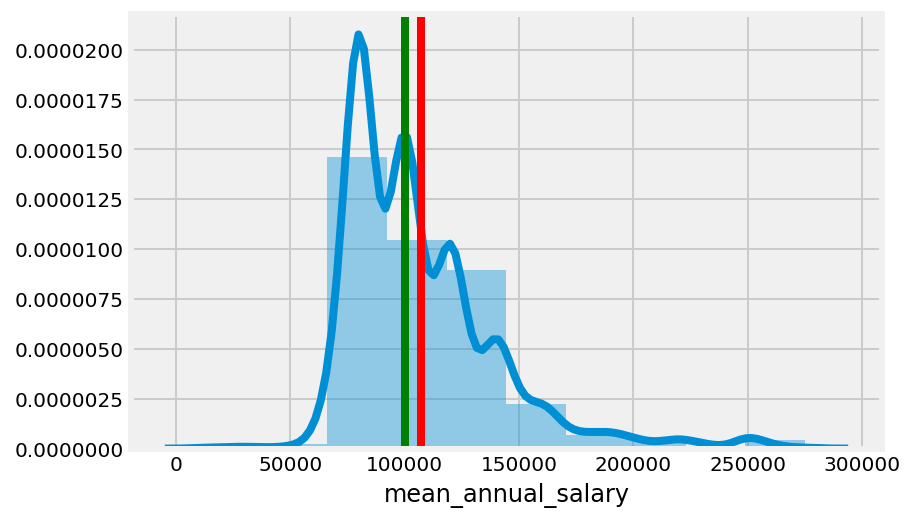

In [677]:
ax = sns.distplot(jobs['annual_salary'], bins=10)
ax.axvline(jobs['mean_annual_salary'].mean(), c='r')
ax.axvline(jobs['mean_annual_salary'].median(), c='g')

**As the distribution is not normally distributed, then I use the median value to define salary_class**

In [781]:
median_salary = np.median(jobs.mean_annual_salary)
median_salary

100000.0

In [782]:
jobs['salary_class'] = [1 if i > median_salary else 0 for i in jobs.mean_annual_salary]

In [784]:
jobs.salary_class.value_counts()

0    1890
1    1203
Name: salary_class, dtype: int64

In [785]:
jobs.head(5)

,city,company,job_description,summary,title,state,mean_annual_salary,salary_class,text
0,Sydney,University of New South Wales,The Organisation UNSW is currently implementin...,You are a PhD qualified scientist with extensi...,Imaging Scientist in Systems Microscopy,NSW,94935.0,0,Sydney Imaging Scientist in Systems Microscopy...
1,Sydney,Environmental Resource Management,Environmental Scientist Site Investigation Ris...,Environmental Scientist – Site Investigation &...,Environmental Scientist,NSW,67123.0,0,Sydney Environmental Scientist Environmental S...
2,Sydney,Correlate Resources,Our client is an industry pioneering Customer ...,As a Junior Data Scientist the responsibilitie...,Junior Data Scientist,NSW,80000.0,0,Sydney Junior Data Scientist As a Junior Data ...
3,Sydney,"Alteryx, Inc.",Position Customer Support Engineer APAC Locati...,Revolutionizing business through data science ...,Customer Support Engineer (APAC),NSW,90000.0,0,Sydney Customer Support Engineer (APAC) Revolu...
4,Sydney,Skippr Cash Flow,About the Company Skippr is an innovative fina...,"An Australian business with global ambitions, ...",Operational Risk Associate,NSW,65000.0,0,Sydney Operational Risk Associate An Australia...


In [786]:
jobs.to_csv('JobsFromIndeedPreprocessed.csv')

In [ ]:
# Some EDA ......., heatmap...
# plot mean_salary group by city
"""
xy = df.groupby(['area']).salary.mean()
xy_df = pd.DataFrame(xy)
xy_df = xy_df.sort_values(by = 'salary', ascending= False)


plt.figure(figsize=(15,10))
ax = sns.boxplot(x="salary", y='area', data=df, order = xy_df.index)
ax.set_ylabel('Area', fontsize = 20)
ax.set_xlabel('Salary', fontsize = 20)
ax.tick_params(labelsize=20)
plt.show()
"""

In [787]:
# baseline accuracy
print(1890/3093)

0.6110572259941804


## 2. Building Classifier Models:

####  My target is to build a number of Classifier to predict the salary_class which has 2 values: 0 or 1

0: low salary (salary under median salary)

1: high salary (salay above median salary) 


In [951]:
# make a copy of dataset
jobs1 = jobs

In [952]:
#jobs1.drop(['salary','location'], axis = 1, inplace = True)
jobs1.head(2)

,city,company,job_description,summary,title,state,mean_annual_salary,salary_class,text
0,Sydney,University of New South Wales,The Organisation UNSW is currently implementin...,You are a PhD qualified scientist with extensi...,Imaging Scientist in Systems Microscopy,NSW,94935.0,0,sydney imaging scientist in systems microscopy...
1,Sydney,Environmental Resource Management,Environmental Scientist Site Investigation Ris...,Environmental Scientist – Site Investigation &...,Environmental Scientist,NSW,67123.0,0,sydney environmental scientist environmental s...


In [953]:
# combine 3 cols city, summary and title into 1 col called 'text'

In [5]:
# converts text to raw text with no punctuations or numbers.
def clean_text(row):

    regex = re.compile("[^a-zA-Z']")
    row = row.lower()
    row = regex.sub(' ', row)
    row = ' '.join(row.split())
    regex = re.compile("\'")
    row = regex.sub('', row)

    return row


def standardize(row):
    """
       Standardize text variations: 'post doc'|'postdoctoral'|'post doctoral' -> 'phd',
                                    'sr' -> 'senior', 'jr' -> 'junior',
                                    'ai' -> 'artificial intelligence', 'ml' -> 'machine learning',
     """
    
    row = row.replace(r'post doc', 'phd').replace(r'postdoctoral', 'phd').replace(r'post doctoral', 'phd')
    row = row.replace(r'sr','senior').replace(r'jr','junior')
    row = row.replace(r'ai','artificial intelligence')
    row = row.replace(r'scientists','scientist')
    row = row.replace(r'ml','machine learning')
    row = row.replace(r'analytics','analytic')
    row = row.replace(r'analysts','analyst')

    return row


def combine_text(row):
    
    city = row['city']
    summary = row['summary']
    title = row['title']
    text = city + ' ' + title + ' ' + summary
    
    return text

In [977]:
jobs1['text'] = jobs1.apply(combine_text, axis=1)
jobs1['text'] = jobs1['text'].apply(clean_text)
jobs1['text'] = jobs1['text'].apply(standardize)

In [971]:
jobs1.salary_class.value_counts()

0    1890
1    1203
Name: salary_class, dtype: int64

In [978]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]\\b')

In [979]:
#jobs_text = jobs1['text'].values
vectorizer.fit(jobs1.text)
text_vec = vectorizer.transform(jobs1.text)

In [980]:
text_vec

<3093x3641 sparse matrix of type '<class 'numpy.float64'>'
	with 48817 stored elements in Compressed Sparse Row format>

In [981]:
# convert the text_vec as a dataframe
df  = pd.DataFrame(text_vec.todense(),
                   columns = vectorizer.get_feature_names())

df.transpose().head(50).transpose()

,aacsb,abap,abilities,ability,able,academic,accc,accelerate,accenture,acceptable,...,acs,act,action,actionable,actions,active,actively,activexchange,activities,activity
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
5,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
6,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
7,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
8,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
9,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [982]:
df.shape

(3093, 3641)

In [849]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [850]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [983]:
X = df
y = jobs['salary_class']

In [1071]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size=0.3)

### 2.1 DecisionTreeClassifier and BaggingClassifier with  DecisionTreeClassifier as the base estimator

In [1073]:
dtc = DecisionTreeClassifier(max_depth=15)
bagger_dtc = BaggingClassifier(base_estimator = dtc, max_samples=1.)

In [1078]:
dtc.fit(X_train, y_train)
print(('Decision Tree Classifier accuracy score:', dtc.score(X_test, y_test)))

bagger_dtc.fit(X_train, y_train)
print(('Bagging Decision Tree Classifier accuracy score:', bagger_dtc.score(X_test, y_test)))

('Decision Tree Classifier accuracy score:', 0.7047413793103449)
('Bagging Decision Tree Classifier accuracy score:', 0.7521551724137931)


In [988]:
print(dtc.score(X_train, y_train))
print(bagger_dtc.score(X_train, y_train))

0.8323325635103926
0.8748267898383372


### 2.2 Cross-validation DTC and Bagging DTC

In [991]:
print(("DTC mean accuracy score on test data:\t", cross_val_score(dtc, X_test, y_test, cv=10).mean()))
print(("BaggingDTC mean accuracy score on test data:\t", cross_val_score(bagger_dtc, X_test, y_test, cv=10).mean()))

('DTC mean accuracy score on test data:\t', 0.6779010374702834)
('BaggingDTC mean accuracy score on test data:\t', 0.6843432007400556)


### 2.3 Random Forest Classifier

In [993]:
# building RandomForestClassifier
random_forest_dtc = RandomForestClassifier(max_depth=None, n_estimators=10, max_features = 300)
random_forest_dtc.fit(X_train, y_train)
predictions = random_forest_dtc.predict(X_test)
print(('Random Forest accuracy:', accuracy_score(y_test, predictions)))

('Random Forest accuracy:', 0.7650862068965517)


### 2.4 Using GridSearchCV to find the best decision tree classifier

In [1058]:
# set up parameter for gridsearchCV
dtc_params = {
    'max_depth':[None, 5,10,15,20],
    'max_features':[None, 50, 100, 200, 300],
    'min_samples_split':[10,15,20,25,30]
}

from sklearn.model_selection import GridSearchCV

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

In [1059]:
dtc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=1)]: Done 625 out of 625 | elapsed:  3.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 5, 10, 15, 20], 'max_features': [None, 50, 100, 200, 300], 'min_samples_split': [10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [1064]:
dtc_best = dtc_gs.best_estimator_ 
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

{'max_depth': None, 'max_features': 200, 'min_samples_split': 10}
0.7413394919168591


In [755]:
# Print out feature importance

In [865]:
fi = pd.DataFrame({
        'feature':df.columns, #X_train.colmns
        'importance':dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi.head(20)

,feature,importance
859,data,0.025123
1900,leading,0.022359
2317,organisation,0.019173
3244,sydney,0.018159
1146,engineer,0.018012
168,analytics,0.017941
2090,melbourne,0.017409
2013,manager,0.017347
461,canberra,0.016504
163,analyst,0.015376


### 2.5 Support Vector Machine : Support Vector Classifier

In [869]:
from sklearn import svm

clf = svm.SVC(kernel='linear')
print(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

0.7630421723433718


In [870]:
print(cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy').mean())

0.6950503444621091


### 2.5 Using GridSearchCV for finding the optimal hyperarameters for SVM

In [833]:
clf_params = {'kernel': ('linear','rbf','poly'), 'C':[1, 5, 10],'gamma': [0.1, 0.001, 0.0001]}
svc = svm.SVC()

#clf_gs = GridSearchCV(svc, clf_params, cv=5, verbose=1)
clf_gs = GridSearchCV(svc, clf_params)

In [834]:
clf_gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf', 'poly'), 'C': [1, 5, 10], 'gamma': [0.1, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [997]:
clf_best = clf_gs.best_estimator_
print((clf_gs.best_params_))
print((clf_gs.best_score_))

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.7644341801385681


In [871]:
# on the test set
clf_best = svm.SVC(C= 10, gamma = 0.001, kernel = 'rbf')
print(cross_val_score(clf_best, X_test, y_test, cv=5, scoring='accuracy').mean())

0.6217683268916665


**Summary**

The following is the summary on the accuracy scores of these above classifiers:
- Decision Tree Classifier : 0.83 (on train data) and 0.70 (on test data)
- Bagging Decision Tree Classifier: 0.87 (on train data) and 0.75 (on test data)
- Decision Tree Classifier mean score with 10 fold cross validation: 0.678 (on test data)
- Bagging Bagging Decision Tree Classifier mean score with 10 fold cross validation: 0.684 (on test data)
- Decision Tree Classifier with the best hyperparameters by using GridSearchCV: 0.765 (on test data)
- Random Forest Classifier: 0.768 (on test data)
- Support Vector Machine (kernel = linear): 0.76 (on train data) and 0.695 (on test data)
- Support Vector Machine with the best hyperparameter by using GridSearchCV: 7.64 (on train data) and 0.62 (on test data)

Compared with the baseline accuracy which is 0.611, the achieved scores is much better.
Howerver, I want to apply number of techniques in order to try increasing the accurary scores. 
In the next sub-section, I will try using PCA technique to reduce the number of features in the training data, then evaluate the accuracy scores again.

### 2.6 PCA to reduce the number of features in training datasets

In [ ]:
# Now I am using PCA to reduce number of features in order to improve the accuracy score.

In [1006]:
df2= df

In [1007]:
df2.head(2)

,aacsb,abap,abilities,ability,able,academic,accc,accelerate,accenture,acceptable,...,yodlee,youd,youll,young,youre,youve,yr,yrs,ze,zerofox
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1008]:
from sklearn.decomposition import PCA

text_vec_pca = PCA(n_components=1000)
df2_pca = text_vec_pca.fit_transform(df2.values)

#print(text_vec_pca.explained_variance_)
print(text_vec_pca.explained_variance_ratio_)
print(text_vec_pca.explained_variance_ratio_.cumsum())

[0.01934684 0.01560079 0.01116446 0.01031841 0.00980948 0.00777147
 0.00742222 0.00700329 0.00672687 0.00650689 0.00646122 0.00606409
 0.00586303 0.00566512 0.00556492 0.00545695 0.00532776 0.0051825
 0.00509721 0.0050528  0.0049751  0.0047586  0.00465556 0.00454893
 0.00449074 0.00437757 0.00434985 0.00429714 0.00426735 0.00420665
 0.00411521 0.00410438 0.00404339 0.00395937 0.00389996 0.00385743
 0.00380624 0.00372807 0.00368765 0.00367163 0.00360324 0.00357731
 0.00351589 0.00345345 0.00340246 0.00339031 0.00334085 0.00332098
 0.00329977 0.00325712 0.00322616 0.00319167 0.00316967 0.003113
 0.00305505 0.00304339 0.00303286 0.00299203 0.0029389  0.00292003
 0.00289516 0.0028635  0.00283362 0.0028121  0.0027851  0.00276645
 0.00273857 0.00270646 0.00269225 0.00265684 0.00262942 0.00261521
 0.00259466 0.00256519 0.00256097 0.00252911 0.00250663 0.00248543
 0.00247772 0.00245542 0.00243934 0.00242725 0.00240007 0.00238874
 0.00237764 0.00233795 0.00233267 0.00231183 0.00228601 0.0022769

In [874]:
# the tranformed dataset (having 1000 features) explain 95.3% of variance of the original dataset
# Now I apply these above learning algorithms with the transformed dataset to see whether the score is improved or not
# (500 cols) : 80.1%

In [1009]:
X2 = df2_pca

In [877]:
X2 = (X2 - X2.mean()) / X2.std()

In [1011]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, random_state=99, test_size=0.3)

In [1015]:
dtc_pca = DecisionTreeClassifier(max_depth= None, max_features= 300, min_samples_split= 10)
bagger_dtc_pca = BaggingClassifier(base_estimator = dtc_pca, max_samples=0.5, max_features=0.5)

dtc_pca.fit(X2_train, y2_train)
print(('Decision Tree Classifier accuracy score:', dtc_pca.score(X2_test, y2_test)))

bagger_dtc_pca.fit(X2_train, y2_train)
print(('Bagging Decision Tree Classifier accuracy score:', bagger_dtc_pca.score(X2_test, y2_test)))

('Decision Tree Classifier accuracy score:', 0.7176724137931034)
('Bagging Decision Tree Classifier accuracy score:', 0.7392241379310345)


In [ ]:
# --> the scores are lower

In [1016]:
print(("DTC mean accuracy score on test data:\t", cross_val_score(dtc_pca, X2_test, y2_test, cv=10, n_jobs=-1).mean()))
print(("BaggingDTC mean accuracy score on test data:\t", cross_val_score(bagger_dtc_pca, X2_test, y2_test, cv=10, n_jobs=-1).mean()))

('DTC mean accuracy score on test data:\t', 0.6702125172828822)
('BaggingDTC mean accuracy score on test data:\t', 0.6669976525121105)


In [ ]:
# --> the scores are lower, again

In [1017]:
# using Random Forest Classifier
random_forest_dtc_pca = RandomForestClassifier(max_depth=None, max_features = 300, n_estimators=10)
random_forest_dtc_pca.fit(X2_train, y2_train)
predictions2 = random_forest_dtc_pca.predict(X2_test)
print(('Random Forest accuracy:', accuracy_score(y2_test, predictions2)))

('Random Forest accuracy:', 0.7521551724137931)


In [ ]:
# --> the scores are lower, again

In [1020]:
# Using Support Vector Machine
clf_pca = svm.SVC(C= 10, gamma= 0.001, kernel= 'linear')
print(cross_val_score(clf_pca, X2_train, y2_train, cv=5, scoring='accuracy').mean())

0.7440990834652833


In [1022]:
print(cross_val_score(clf_pca, X2_test, y2_test, cv=5, scoring='accuracy').mean())

0.7080231931085821


In [ ]:
# --> the score is slightly improved on the test set

**Summary**
 
It is obvious to see that the accuracy scores are even lower in most of cases. The behind reason is that using PCA can lose some spatial information which is important for classification.

Now I will use **CountVectorizer** to predict salary rather than using tfidf

### 2.7 Using CountVectorizer

In [1023]:
all_jobs_desc = jobs['text'].values
print(all_jobs_desc)

['sydney imaging scientist in systems microscopy you are a phd qualified scientist with extensive experience in advanced fluorescence microscopy liquid handling automation and bespoke image analysis of'
 'sydney environmental scientist environmental scientist site investigation risk assessment fieldwork experience involving environmental data collection soil and water'
 'sydney junior data scientist as a junior data scientist the responsibilities of this role will involve but not be limited to a genuine passion to build a career in data analytic data'
 ...
 'canberra technology consulting manager business case development robotics process transformation and artificial intelligence proven ability to work creatively and analytically in a client business'
 'canberra project manager ten or more years of demonstrated experience in it delivering infrastructure application or business intelligence projects'
 'canberra project manager ten or more years of demonstrated experience in it deliveri

In [1024]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words="english")
cvec.fit(all_jobs_desc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [1025]:
df_countvecterizer  = pd.DataFrame(cvec.transform(all_jobs_desc).todense(),
             columns=cvec.get_feature_names())

df_countvecterizer.transpose().sort_values(0, ascending=False).head(20).transpose()

,microscopy,scientist,liquid,experience,phd,bespoke,qualified,advanced,sydney,analysis,systems,handling,imaging,fluorescence,image,automation,extensive,pay,perform,performance
0,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0
1,0,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
9,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [1026]:
X3 = df_countvecterizer

In [1027]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, random_state=99, test_size=0.3)

In [1031]:
dtc3 = DecisionTreeClassifier(max_depth = None, max_features = 300, min_samples_split = 10)
bagger_dtc3 = BaggingClassifier(base_estimator = dtc3, max_samples=1.)

In [1033]:
dtc3.fit(X3_train, y3_train)
print(('Decision Tree Classifier accuracy score:', dtc3.score(X3_test, y3_test)))

bagger_dtc3.fit(X3_train, y3_train)
print(('Bagging Decision Tree Classifier accuracy score:', bagger_dtc3.score(X3_test, y3_test)))

('Decision Tree Classifier accuracy score:', 0.728448275862069)
('Bagging Decision Tree Classifier accuracy score:', 0.7586206896551724)


In [1034]:
# --> the scores are slightly improved compared with using tdidf

In [1035]:
# RandomForestClassifier
random_forest_dtc3 = RandomForestClassifier(max_depth=None, n_estimators=10, max_features = 300)
random_forest_dtc3.fit(X3_train, y3_train)
predictions3 = random_forest_dtc3.predict(X3_test)
print(('Random Forest accuracy:', accuracy_score(y3_test, predictions3)))

('Random Forest accuracy:', 0.7683189655172413)


In [ ]:
# --> the scores are quite the same

In [1037]:
# support vector machine
clf3 = svm.SVC(kernel = 'linear')
print(cross_val_score(clf3, X3_train, y3_train, cv=5, scoring='accuracy').mean())
print(cross_val_score(clf3, X3_test, y3_test, cv=5, scoring='accuracy').mean())

0.7551973839027777
0.7005135616900323


In [ ]:
# --> the score on the test set is slightly improved compared with using tdidf

### 2.8 Using Gradient Boosting Classifier

In [949]:
from sklearn.ensemble import GradientBoostingClassifier

In [950]:
# trying GBM with differen learning rates in combination with tfidf

learning_rates = [0.05, 0.1, 0.25, 0.5]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_depth=None, max_features = 300, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.933
Accuracy score (validation): 0.778

Learning rate:  0.1
Accuracy score (training): 0.933
Accuracy score (validation): 0.777

Learning rate:  0.25
Accuracy score (training): 0.933
Accuracy score (validation): 0.775

Learning rate:  0.5
Accuracy score (training): 0.933
Accuracy score (validation): 0.773



In [1039]:
# trying GBM with differen learning rates in combination with CountVectorizer

for learning_rate in learning_rates:
    gb3 = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_depth=None, max_features = 300, random_state = 0)
    gb3.fit(X3_train, y3_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb3.score(X3_train, y3_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb3.score(X3_test, y3_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.933
Accuracy score (validation): 0.780

Learning rate:  0.1
Accuracy score (training): 0.933
Accuracy score (validation): 0.777

Learning rate:  0.25
Accuracy score (training): 0.933
Accuracy score (validation): 0.772

Learning rate:  0.5
Accuracy score (training): 0.933
Accuracy score (validation): 0.778



** Summary**

After using a number of classifier models and text analysing techniques, the highest accuray scores are obtained by using **Gradient Boosting Classifier** at the learning rate 0.05:
    - 0.933 on the training data
    - 0.780 on the testing data

In [1040]:
# feature inportances of the gradient boosting classifier
gb_best = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.05, max_depth=None, max_features = 300, random_state = 0)
gb_best.fit(X3_train, y3_train)
print(gb_best.score(X3_test, y3_test))

0.7801724137931034


In [1045]:
fi_gb = pd.DataFrame({
        'feature':df_countvecterizer.columns,
        'importance':gb_best.feature_importances_
    })

fi_gb.sort_values('importance', ascending=False, inplace=True)
fi_gb.head(30)

,feature,importance
428,business,0.014856
2034,manager,0.013667
3263,sydney,0.013105
150,analyst,0.013027
843,data,0.010051
2112,melbourne,0.009834
411,brisbane,0.009458
2979,senior,0.009433
1232,experience,0.008190
3074,solutions,0.007845


# PART 2: factor to predict job title

In part 2, we will build learing models to identify features in the data related to job postings that can distinguish job category, i.e. Data Scientist or Data Analyst.

I will use the data that I scraped earlier, but filter them to contain Data Scientist or Data Analyst jobs only.

Then I create a column named 'Job_Category' with the value of 0 if the job is Data Analyst or 1 if the job is Data Scientist.

That column will be the target variable.


The predictor variables will be the Summary and the Job Description columns as the job category may depend on the set of the required skills which normally stated in these two columns.

Then I'll use CountVectorizer or TF-IDF to....

In [3]:
jobs2 = pd.read_csv('JobsFromIndeedPreprocessed.csv')
jobs2.head(2)

,Unnamed: 0,city,company,job_description,summary,title,state,mean_annual_salary,salary_class,text
0,0,Sydney,University of New South Wales,The Organisation UNSW is currently implementin...,You are a PhD qualified scientist with extensi...,Imaging Scientist in Systems Microscopy,NSW,94935.0,0,Sydney Imaging Scientist in Systems Microscopy...
1,1,Sydney,Environmental Resource Management,Environmental Scientist Site Investigation Ris...,Environmental Scientist – Site Investigation &...,Environmental Scientist,NSW,67123.0,0,Sydney Environmental Scientist Environmental S...


In [14]:
jobs2.shape

(3093, 11)

In [59]:
jobs2_filtered = jobs2.loc[jobs2['title'].str.contains("analyst|scientist|Analyst|Scientist"),:]

In [60]:
jobs2_filtered.shape

(1100, 11)

In [61]:
jobs2_filtered.head(3)

,Unnamed: 0,city,company,job_description,summary,title,state,mean_annual_salary,salary_class,text,text2
0,0,Sydney,University of New South Wales,The Organisation UNSW is currently implementin...,You are a PhD qualified scientist with extensi...,Imaging Scientist in Systems Microscopy,NSW,94935.0,0,Sydney Imaging Scientist in Systems Microscopy...,you are a phd qualified scientist with extensi...
1,1,Sydney,Environmental Resource Management,Environmental Scientist Site Investigation Ris...,Environmental Scientist – Site Investigation &...,Environmental Scientist,NSW,67123.0,0,Sydney Environmental Scientist Environmental S...,environmental scientist site investigation ris...
2,2,Sydney,Correlate Resources,Our client is an industry pioneering Customer ...,As a Junior Data Scientist the responsibilitie...,Junior Data Scientist,NSW,80000.0,0,Sydney Junior Data Scientist As a Junior Data ...,as a junior data scientist the responsibilitie...


In [63]:
jobs2_filtered['job_category'] = [1 if "Scientist" in i or "scientist" in i else 0 for i in jobs2_filtered.title]

C:\Users\HaNguyen\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
jobs2_filtered.drop('text', axis = 1, inplace = True)
jobs2_filtered.head(3)

C:\Users\HaNguyen\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Unnamed: 0,city,company,job_description,summary,title,state,mean_annual_salary,salary_class,text2,job_category
0,0,Sydney,University of New South Wales,The Organisation UNSW is currently implementin...,You are a PhD qualified scientist with extensi...,Imaging Scientist in Systems Microscopy,NSW,94935.0,0,you are a phd qualified scientist with extensi...,1
1,1,Sydney,Environmental Resource Management,Environmental Scientist Site Investigation Ris...,Environmental Scientist – Site Investigation &...,Environmental Scientist,NSW,67123.0,0,environmental scientist site investigation ris...,1
2,2,Sydney,Correlate Resources,Our client is an industry pioneering Customer ...,As a Junior Data Scientist the responsibilitie...,Junior Data Scientist,NSW,80000.0,0,as a junior data scientist the responsibilitie...,1


In [88]:
jobs2_filtered.drop('title', axis = 1, inplace = True)

C:\Users\HaNguyen\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [89]:
jobs2_filtered.job_category.value_counts()

0    733
1    367
Name: job_category, dtype: int64

In [103]:
# baseline
print(733/1100)

0.6663636363636364


In [90]:
# target variable: job_category
# predictor variable: text2
# Now I am gonna use CounVectorizer

In [91]:
def combine_text_2(row):
    
    summary2 = row['summary']
    job_desc = row['job_description']
    text2 = summary2 + ' ' + job_desc
    
    return text2

jobs2_filtered['text2'] = jobs2_filtered.apply(combine_text_2, axis=1)
jobs2_filtered['text2'] = jobs2_filtered['text2'].apply(clean_text)
jobs2_filtered['text2'] = jobs2_filtered['text2'].apply(standardize)

C:\Users\HaNguyen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\HaNguyen\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HaNguyen\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [92]:
all_jobs_desc_2 = jobs2_filtered['text2'].values

from sklearn.feature_extraction.text import CountVectorizer
cvec2 = CountVectorizer(stop_words="english")
cvec2.fit(all_jobs_desc_2)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [93]:
df_countvecterizer_2  = pd.DataFrame(cvec2.transform(all_jobs_desc_2).todense(),
             columns=cvec2.get_feature_names())

df_countvecterizer_2.transpose().sort_values(0, ascending=False).head(20).transpose()

,research,microscopy,facility,data,analysis,unsw,imaging,unit,advanced,scientist,systems,handling,position,bmif,automation,image,description,biomedical,collaborate,university
0,7,7,6,6,5,5,4,3,3,3,3,3,3,3,3,3,3,3,2,2
1,0,0,0,2,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
2,0,0,0,14,6,0,0,0,0,3,1,0,1,0,0,0,0,0,0,0
3,0,0,0,13,5,0,0,0,0,4,1,0,1,0,0,0,0,0,0,0
4,0,0,0,10,8,0,0,0,1,5,0,0,1,0,0,0,0,0,0,0
5,0,0,0,21,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0
6,1,0,0,6,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0
7,0,0,0,4,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0
8,0,0,0,11,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [94]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [97]:
X_jt = df_countvecterizer_2
y_jt = jobs2_filtered['job_category']

In [98]:
X_jt_train, X_jt_test, y_jt_train, y_jt_test = train_test_split(X_jt, y_jt, random_state=99, test_size=0.3)

### Decision Tree Classifier and Bagging Decision Tree Classifier

In [100]:
dtc_jt = DecisionTreeClassifier(max_depth = None, min_samples_split = 10)
bagger_dtc_jt = BaggingClassifier(base_estimator = dtc_jt, max_samples=1.)

In [101]:
dtc_jt.fit(X_jt_train, y_jt_train)
print(('Decision Tree Classifier accuracy score:', dtc_jt.score(X_jt_test, y_jt_test)))

bagger_dtc_jt.fit(X_jt_train, y_jt_train)
print(('Bagging Decision Tree Classifier accuracy score:', bagger_dtc_jt.score(X_jt_test, y_jt_test)))

('Decision Tree Classifier accuracy score:', 0.9878787878787879)
('Bagging Decision Tree Classifier accuracy score:', 0.9818181818181818)


### Random Forest Classifier

In [102]:
# RandomForestClassifier
random_forest_dtc_jt = RandomForestClassifier(max_depth=None, n_estimators=10)
random_forest_dtc_jt.fit(X_jt_train, y_jt_train)
predictions_jt = random_forest_dtc_jt.predict(X_jt_test)
print(('Random Forest accuracy:', accuracy_score(y_jt_test, predictions_jt)))

('Random Forest accuracy:', 0.9696969696969697)


### Gradient Boosting Classifier

In [104]:
from sklearn.ensemble import GradientBoostingClassifier

In [105]:
learning_rates = [0.05, 0.1, 0.25, 0.5]

In [106]:
for learning_rate in learning_rates:
    gb_jt = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_depth=None, random_state = 99)
    gb_jt.fit(X_jt_train, y_jt_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_jt.score(X_jt_train, y_jt_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_jt.score(X_jt_test, y_jt_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (validation): 0.988

Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (validation): 0.988

Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.988

Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.988



In [111]:
fi_gb = pd.DataFrame({
        'feature':df_countvecterizer_2.columns,
        'importance':gb_jt.feature_importances_
    })

fi_gb.sort_values('importance', ascending=False, inplace=True)
fi_gb.head(50)

,feature,importance
6939,scientist,0.529900
4669,machine,0.088599
348,analyst,0.063735
6606,reporting,0.018423
7437,stakeholders,0.017384
2844,exist,0.014413
6819,ronny,0.012796
1962,data,0.007082
6934,science,0.006224
2319,dmp,0.005731
